## Анализ отзывов

В рамках данного кейса предлагается с помощью ИИ и машинного обучения поизучать отзывы людей на железнодорожные вокзалы Москвы. В рамках кейса предоставляются отзывы пользователей с Яндекс-карт, но возможно дополнительно использовать доступные в Интернет данные. 

Что ожидается в качестве результата:
* Инфографика, наглядно демонстрирующая полученные командой результаты
* Доклад, представляющий эти результаты
* Код в Jupyter Notebook с анализом данных

В данном ноутбуке показывается, как получить доступ к датасету, и первые шаги по его обработке с помощью доступных открытых моделей с HuggingFace, и с помощью YandexGPT. Можно использовать данный ноутбук как оправную точку для выполнения задания, расширив его дополнительными идеями, например:
* Кластеризация отзывов
* Обучение своих моделей для классификации тематики отзывов
* Использование предобученных NER-моделей
* Подробный анализ отзывов с помощью LLM

> В начале работы мы будем использовать модель с HuggingFace, поэтому работа будет быстрее, если вы будете запускать код на узле с поддержкой GPU

### Получение датасета

In [1]:
!wget http://www.soshnikov.com/temp/data/rail_reviews.zip

--2024-05-22 07:52:38--  http://www.soshnikov.com/temp/data/rail_reviews.zip
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 390394 (381K) [application/zip]
Saving to: ‘rail_reviews.zip’

     0K .......... .......... .......... .......... .......... 13% 2.72M 0s
    50K .......... .......... .......... .......... .......... 26% 7.62M 0s
   100K .......... .......... .......... .......... .......... 39% 5.74M 0s
   150K .......... .......... .......... .......... .......... 52% 7.00M 0s
   200K .......... .......... .......... .......... .......... 65% 6.65M 0s
   250K .......... .......... .......... .......... .......... 78% 6.64M 0s
   300K .......... .......... .......... .......... .......... 91% 6.01M 0s
   350K .......... .......... .......... .                    100% 7.12M=0.07s

2024-05-22 07:52:38 (5.56 MB/s) - ‘rail_re

In [2]:
!unzip *.zip

Archive:  rail_reviews.zip
  inflating: reviews_Belorussky_railway_station.json  
  inflating: reviews_Kazan_Station.json  
  inflating: reviews_Kursky_station.json  
  inflating: reviews_Kyiv_railway_station.json  
  inflating: reviews_Paveletsky_railway_station.json  
  inflating: reviews_Rizhsky_railway_station.json  
  inflating: reviews_Savyolovsky_station.json  
  inflating: reviews_Vostochny_station.json  


### Преобразуем данные в DataFrame

Как видите, каждый вокзал представлен своим набором отзывов следующего вида:

In [2]:
import json
j = json.load(open('reviews_Belorussky_railway_station.json'))
j[0]

{'id': 1251,
 'dislike': 1,
 'like': 10,
 'review_text': 'Очень красивое место, вежливый персонал.\nЕздила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.',
 'author': 'Александра Подгайская',
 'review_rating': 5,
 'datetime': '2024-01-12T16:53:33.611Z'}

Для удобства, сведём все отзывы в одну табличку. Для этого нам нужно будет добавить в каждое JSON-описание отзыва название вокзала.

In [6]:
import pandas as pd
import os
from glob import glob

res = []
for fn in glob('*.json'):
    j = json.load(open(fn))
    for x in j:
        x['station'] = fn.split('_')[1]
    res.extend(j)
    
df = pd.DataFrame(res)
df

,id,dislike,like,review_text,author,review_rating,datetime,station
0,1251,1,10,"Очень красивое место, вежливый персонал.\nЕзди...",Александра Подгайская,5,2024-01-12T16:53:33.611Z,Belorussky
1,1252,0,5,"Расположен очень удобное, строятся новые пути ...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky
2,1253,2,7,Очень уютный и удобный вокзал. Мне он очень нр...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky
3,1254,1,5,"Красивое здание , очень удобно расположено в т...",Liliya Zugrova,5,2023-11-27T11:50:16.388Z,Belorussky
4,1255,2,7,С появление новых веток и маршрутов все стало ...,Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky
...,...,...,...,...,...,...,...,...
2264,2266,0,1,"Отличный вокзал. Новый, современный, прям из в...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny
2265,2267,1,0,Бывал недавно там )) очень вкусная кухня \nКла...,Дмитрий,5,2023-11-12T14:21:47.541Z,Vostochny
2266,2268,0,0,Отличный и красивый вокзал. Чистые туалеты и б...,Валентина Архимановна,5,2024-01-31T10:53:36.364Z,Vostochny
2267,2269,3,10,"Это не вокзал , а скорее узловая станция или п...",Владислав Баранов,2,2023-12-06T12:03:14.107Z,Vostochny


Посмотрим на количество отзывов по вокзалам:

<Axes: xlabel='station'>

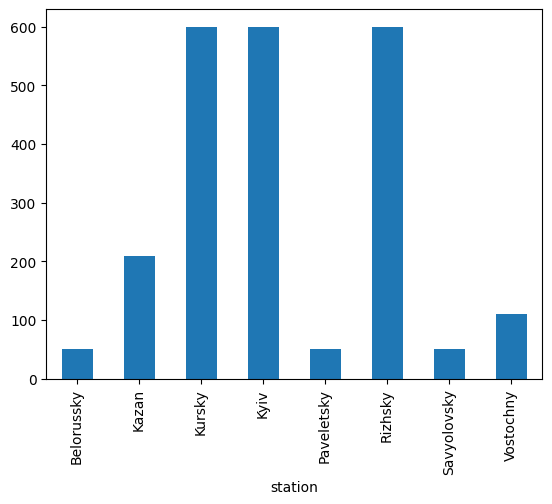

In [4]:
df.groupby('station')['review_text'].count().plot.bar()

### Обогащение данных

Для обогащения данных можно использовать различные нейросетевые модели. Для начала, попробуем определить тональность текста.

Попробуем использовать модель [blanchefort/rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews) с HuggingFace, натренированную на отзывах, с длиной 512 токенов. По умолчанию код из карточки модели выдает следующие классы:
* 0: NEUTRAL
* 1: POSITIVE
* 2: NEGATIVE

> Код не учитывает возможность работы на GPU, поэтому придётся внести в код несколько исправлений, чтобы можно было быстрее выполнять код на GPU.

In [7]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', return_dict=True)
model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Проверим, работает ли эта функция:

In [8]:
predict([
    'Ничего так вокзал, обычный...',
    'Обожаю этот вокзал, там такие симпатичные бомжи!',
    'Ненавижу это вокзал, поезда всегда опаздывают минимум на 20 минут'])

array([0, 1, 2])

Чтобы применить модель ко всему датасету, разобьем его на небольшие части, примерное по 200 отзывов, и предскажем тональность каждой из этих частей.

In [9]:
from tqdm.auto import tqdm
import numpy as np 

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)

100%|██████████| 10/10 [15:23<00:00, 92.35s/it] 


Для удобства вставим колонку `sentiment` в датасет, но при этом изменим кодирование: будем представлять негативный отзыв цифрой -1.

In [10]:
df['sentiment'] = pd.Series(res).apply(lambda x: -1 if x==2 else x)

Запишем получившийся датасет на диск:

In [11]:
df.to_csv('dataset_with_sentiment.csv',index=False)

Теперь можем посмотреть, какие вокзалы самые негативные или позитивные в Москве:

In [12]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()


df.groupby('station').agg({'sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

sentiment                     review_text
                 mean count_pos count_neg       count
station                                              
Belorussky   0.680000        36         2          50
Kazan        0.647619       143         7         210
Kursky       0.395000       277        40         600
Kyiv         0.599332       385        26         599
Paveletsky   0.540000        27         0          50
Rizhsky      0.560000       374        38         600
Savyolovsky  0.480000        29         5          50
Vostochny    0.618182        71         3         110

В этом месте вы можете остановить виртуальную машину с GPU и перейти на более дешевый вариант **c1.4**

### Используем YandexGPT для извлечение отзывов

Попробуем использовать больщую языковую модель для извлечения структурированной информации из текстов отзывов. Для этого нам будет удобно использовать библиотеку [yandex_chain](https://github.com/yandex-datasphere/yandex-chain).

In [2]:
%pip install yandex_chain

Defaulting to user installation because normal site-packages is not writeable
  Using cached yandex_chain-0.0.7-py3-none-any.whl

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


Для работы с YandexGPT, нам потребуются значения `api_key` и `folder_id`. Их надо взять из секретов датасферы.

In [19]:
folder_id = "b1gst3c7cskk2big5fqn"
api_key = "AQVN0-FV0kOBiKSo26Wi-jZCLPPoOdyBjGHs3pXV"

Создадим объект YandexGPT и проверим, как он работает:

In [23]:
from yandex_chain import YandexLLM, YandexGPTModel
LLM = YandexLLM(model=YandexGPTModel.Pro, folder_id=folder_id, api_key=api_key)

LLM.invoke("Расскажи анекдот про JSON и XML")

'Программисту на ушко:\n\n— Я слышал в JSON всё-таки внедрили поддержку кириллицы!\n— О, тогда мне больше не нужно писать эти огромные комментарии для заказчиков на английском! Поддерживает же!'

Для обработки выберем по 10 записей из каждого вокзала:

In [24]:
import pandas as pd

df = pd.read_csv('dataset_with_sentiment.csv')
df_sample = df.groupby('station').apply(lambda x: x.sample(10)).reset_index(drop=True)
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,sentiment
0,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,1
1,1283,0,6,"Большой просторный, красивый вокзал. Зал ожида...",Мария Рыжкова,5,2024-01-20T08:19:35.208Z,Belorussky,1
2,1279,0,0,"Один из красивых вокзалов, г. Москвы, \nХороше...",Лекс,5,2023-11-04T12:49:54.572Z,Belorussky,1
3,1300,7,21,"Удобно расположен, есть камеры хранения, возмо...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,0
4,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,1
...,...,...,...,...,...,...,...,...,...
75,2198,0,0,"Небольшой вокзал на востоке столицы, с удобной...",Андрей Кочкин,4,2024-01-06T09:36:59.239Z,Vostochny,0
76,2175,0,0,"Вокзал свежий,но очень маленький.Иногда большо...",Анна Тихонова,4,2024-01-20T12:28:08.435Z,Vostochny,0
77,2270,0,3,Очень приятный новый вокзал! Разобраться сложн...,Наталья Байбакова,5,2023-12-24T13:10:29.484Z,Vostochny,1
78,2180,1,0,"Посещал данный вокзал, из преимуществ, есть по...",Tomm,5,2023-10-29T11:07:27.166Z,Vostochny,1


Попробуем выделить смысл из текста отзыва. Для примера выберем три аспекта отзывов: транспортная доступность вокзала, его чистота и точность хождения поездов. По каждому из этих аспектов попробуем выделить оценку, также в целом положительные и отрицательные моменты, и список тегов, о чем этот отзыв.

In [25]:
prompt = """
Прочитай следующий отзыв о вокзале в тройных обратных кавычках: ````{}```.
Из этого отзыва тебе необходимо выделить следующую информацию:
* sentiment - этот отзыв позитивный (positive), негативный (negative) или нейтральный (neutral)
* transport - транспортная доступность вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* cleanliness - чистота вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* schedule - точность хождения поездов, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* positive - краткий список позитивных моментов из отзыва
* negative - краткий список негативных моментов из отзыва
* tags - краткий список тегов, о чем этот отзыв, например: cleanliness, transport, trains
Результат необходимо вернуть в формате JSON такого вида:
{{
  "sentiment" : "...",
  "transport" : ...,
  "cleanliness" : ...,
  "schedule" : ...,
  "positive" : ["...", ...],
  "negative" : ["...", ...],
  "tags" : ["..."]
}}
"""

txt = df['review_text'].iloc[0]
print(txt)
res = LLM.invoke(prompt.format(txt))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


'{\n  "sentiment": "positive",\n  "transport": 0,\n  "cleanliness": 5,\n  "schedule": 0, \n  "positive": ["очень красивое место", "вежливый персонал", "комфортно", "чистое бельё", "тепло", "квалифицированные сотрудники"],\n  "negative": [],\n  "tags": []\n}'

Поскольку возврат результата в формате JSON не гарантируется, попробуем использовать JsonOutputParser из библиотки LangChain для выделения результата в формате JSON. Но в дальнейшем если будут возникать ошибки парсинга - мы будет просто игнорировать такие строки.

In [26]:
from langchain_core.output_parsers import JsonOutputParser
jop = JsonOutputParser()

txt = df['review_text'].iloc[0]
print(txt)
res = jop.parse(LLM.invoke(prompt.format(txt)).replace('\'','"'))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


{'sentiment': 'positive',
 'transport': 0,
 'cleanliness': 1,
 'schedule': 0,
 'positive': ['вежливый персонал',
  'комфортно',
  'чистое бельё',
  'тепло',
  'квалифицированные сотрудники'],
 'negative': [],
 'tags': []}

Сохраним колонку `sentiment`, распознанную моделью HuggingFace.

In [27]:
pmap = { -1 : 'negative', 0 : 'neutral', 1 : 'positive' }
df_sample['hf_sentiment'] = df_sample['sentiment'].apply(lambda x: pmap[x])
df_sample.drop(columns=['sentiment'],inplace=True)

Теперь пройдёмся по всем строкам таблицы и извлечём информацию с помощью LLM:

In [42]:
from tqdm.auto import tqdm
from json import JSONDecodeError
import numpy as np

def lin(x):
    if isinstance(x,list):
        return ','.join(x)
    else:
        return x

for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
    df_sample[f]=np.nan

for i,r in tqdm(df_sample.iterrows()):
    txt = r['review_text']
    try:
        res = jop.parse(LLM.invoke(prompt.format(txt)).replace('\'','"'))
        for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
            df_sample.at[i,f] = lin(res[f])
    except Error as e:
        print(f'Error: {e}') 

1it [00:02,  2.06s/it]

positive
3
0
0
['уникальная история вокзала', 'интересная архитектура', 'активное обновление вокзала', 'аэропоезд Ласточка']
[]
['вокзал', 'Ласточка']


2it [00:04,  2.14s/it]

positive
1
0
0
['большой просторный уютный вокзал', 'зал ожидания уютнее, чем на других вокзалах города', 'экспресс электрички до аэропортов', 'удобное расположение в центре города', 'рядом метро Белорусская']
[]
['вокзал']


3it [00:06,  2.05s/it]

positive
1
0
0
['красивый', 'хорошее расположение', 'удобная транспортная доступность', 'есть где покушать']
[]
['вокзал', 'транспортная доступность']


3it [00:08,  2.83s/it]


YException: Error calling YandexGPT after 3 retries. Result returned:
{'error': {'grpcCode': 8, 'httpCode': 429, 'message': 'ai.textGenerationCompletionRequestsPerHour.rate rate quota limit exceed: allowed 100 requests', 'httpStatus': 'Too Many Requests', 'details': []}}

Посмотрим на результат:

In [43]:
df_sample.to_csv('dataset_sample_with_GPT.csv')
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment,sentiment,transport,cleanliness,schedule,positive,negative,tags
0,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,positive,positive,3.0,0.0,0.0,"уникальная история вокзала,интересная архитект...",,"вокзал,Ласточка"
1,1283,0,6,"Большой просторный, красивый вокзал. Зал ожида...",Мария Рыжкова,5,2024-01-20T08:19:35.208Z,Belorussky,positive,positive,1.0,0.0,0.0,"большой просторный уютный вокзал,зал ожидания ...",,вокзал
2,1279,0,0,"Один из красивых вокзалов, г. Москвы, \nХороше...",Лекс,5,2023-11-04T12:49:54.572Z,Belorussky,positive,positive,1.0,0.0,0.0,"красивый,хорошее расположение,удобная транспор...",,"вокзал,транспортная доступность"
3,1300,7,21,"Удобно расположен, есть камеры хранения, возмо...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2198,0,0,"Небольшой вокзал на востоке столицы, с удобной...",Андрей Кочкин,4,2024-01-06T09:36:59.239Z,Vostochny,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,2175,0,0,"Вокзал свежий,но очень маленький.Иногда большо...",Анна Тихонова,4,2024-01-20T12:28:08.435Z,Vostochny,neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2270,0,3,Очень приятный новый вокзал! Разобраться сложн...,Наталья Байбакова,5,2023-12-24T13:10:29.484Z,Vostochny,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,2180,1,0,"Посещал данный вокзал, из преимуществ, есть по...",Tomm,5,2023-10-29T11:07:27.166Z,Vostochny,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN
